In [1]:
import sys
sys.path.insert(0, "/users/jwindmil/2019_WMI/util")

# Initial imports
import Landau_Potential_Diffusion as Landau
import curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd
import dask.array as da

import pickle

In [2]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [3]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind 

In [4]:
def cm_to_inch(m_cm):
    return m_cm/2.54

In [5]:
path = '/project/s916/ERA5_Tom/'
path_PKL = '/users/jwindmil/2019_WMI/dev/jwindmiller/PKL_DATA/'

Restrict our analysis to a band of the tropical Atlantic

In [6]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

Select period (exclude 2018 as it is only partly available)

In [7]:
date1, date2 = np.datetime64('2000-01-01T00:00'), np.datetime64('2017-12-31T23:00')
dt = 3600

In [8]:
PW = xr.open_mfdataset(path+'????/??PW.nc',combine='by_coords', chunks={'time':100})

In [9]:
PWAtl = PW['tcwv'].sel({'time':slice(date1, date2), 'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [10]:
time_A = PWAtl.time.values

## Bimodality of CWV

i) use the entire available period to calculate the distribution of CWV in the reanalysis data

ii) compare with the time evolutio of the humidity distribution of CWV in the RCE simulation

In [11]:
# chunk_sz = 1000
# ind_chunks = list(range(0, np.shape(PWAtl)[0], chunk_sz))+[np.shape(PWAtl)[0]]
# nbins = 80
# bin_edges = np.linspace(0, 80, nbins + 1)
# total = np.zeros(nbins, np.uint)

# for i in range(len(ind_chunks)-1):
#     print('i=',i, end='\r')
#     ind_start, ind_end = ind_chunks[i], ind_chunks[i+1]
#     data_chunk = np.ndarray.flatten(PWAtl[ind_start:ind_end,:,:].values)
#     subtotal, e = np.histogram(data_chunk, bin_edges)
#     total+= subtotal.astype(np.uint)
#     del data_chunk, subtotal, e

# hist_total = np.copy(total)
# np.savez('./PKL_DATA/CWV_hist_%i_%i_%i_%i.npz'%(latmin, latmax, lonmin, lonmax), hist_total = hist_total, bin_edges = bin_edges)

dic_hist = np.load('./PKL_DATA/CWV_hist_%i_%i_%i_%i.npz'%(latmin, latmax, lonmin, lonmax))

hist_total = dic_hist['hist_total']
bin_edges = dic_hist['bin_edges']

In [12]:
hist_cum = np.cumsum(hist_total)/np.sum(hist_total)

In [13]:
hist_total = hist_total/np.sum(hist_total)

(array([29, 52]),) (array([47]),)


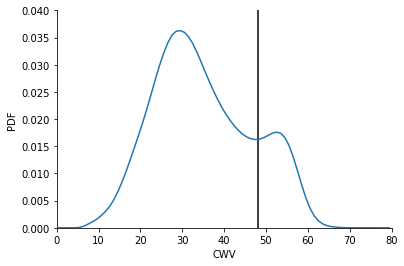

In [14]:
thresh = 48.0
per_thresh = 83

bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

plt.subplot(111)
plt.plot(bin_centers, hist_total)

print(argrelextrema(hist_total, np.greater), argrelextrema(hist_total, np.less))
plt.vlines([thresh], 0, 0.040)
plt.xlim(0, 80)
plt.ylim(0, 0.040)
plt.xlabel('CWV')
plt.ylabel('PDF')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



percentile corresponding to 48 mm: 83


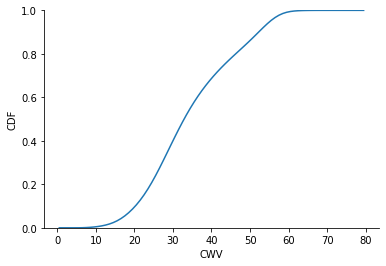

In [15]:
plt.plot(bin_centers, hist_cum)
plt.ylim(0,1)

per_thresh = int(100*hist_cum[np.where(bin_centers>=thresh)][0])

print('percentile corresponding to %i mm: %i'%(thresh, per_thresh))
plt.xlabel('CWV')
plt.ylabel('CDF')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)



## Bimodality due to bistability?

i) calculate potential from CWV tendencies in reanalysis data - do systematic analysis i.e. how often bistable? Local maximum close to 48 mm? 

ii) repeat for RCE simulation

Use time-evolution of variance of PDF to determine the time period for calculating the potential. 

In [16]:
hf = open('PKL_DATA/STAT_LSM_%i_%i_%i_%i.pkl'%(latmin, latmax,lonmin,lonmax),'rb')
STAT_data = pickle.load(hf)
STD_PW = STAT_data['STD']
time_stat = STAT_data['time']

STD_PW_all = get_all_values(STD_PW)

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(6, 14)

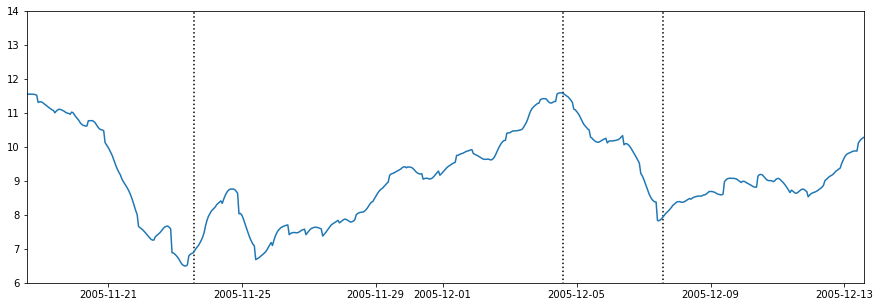

In [17]:
plt.figure(figsize=(15,5))
plt.plot(time_A, STD_PW_all)

time_std_max = time_A[np.argsort(STD_PW_all)][100] #time_A[np.argmin(STD_PW_all)]

plt.xlim(time_std_max-np.timedelta64(6, 'W'), time_std_max+np.timedelta64(26, 'W'))

times_A = [time_std_max, time_std_max+np.timedelta64(11, 'D'), time_std_max+np.timedelta64(14, 'D')]

plt.xlim(time_std_max-np.timedelta64(5, 'D'), time_std_max+np.timedelta64(20, 'D'))
ymin, ymax = plt.ylim()
plt.vlines(times_A, ymin, ymax, linestyle = ':')
plt.ylim(6, 14)

Calculate time-tendency of MSE

In [18]:
# np.datetime64('year-month-day')

times_Vstart = times_A[0] 
times_Vend   = times_A[1] 

ileftV = find_index(time_A, np.datetime64(times_Vstart))
irightV = find_index(time_A, np.datetime64(times_Vend))

In [19]:
PWAtl_res = PWAtl[ileftV-1:irightV+2,:,:].values # If can't fit in the memory, can't calculate potential

In [20]:
dPW_dt = (PWAtl_res[2:,:,:]-PWAtl_res[:-2,:,:])/(2*dt)

In [21]:
tmp,binm_Vfinal,Vfinal = Landau.Landau_energy(PWAtl_res[1:-1,:,:],dPW_dt,N_bins=50)

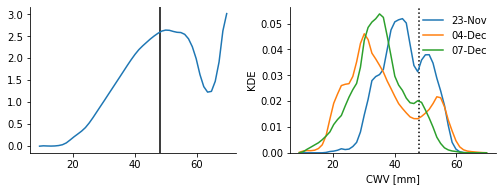

In [22]:
plt.figure(figsize=(cm_to_inch(18), cm_to_inch(7)))

plt.subplot(121)
plt.plot(binm_Vfinal,Vfinal*1e4)
#plt.xlim(25, 65)
ymin, ymax = plt.ylim()
plt.vlines([48], ymin, ymax)
plt.ylim(ymin, ymax)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.subplot(122)

#times_A = [np.datetime64('2009-05-14T00:00'), np.datetime64('2009-05-18T18:00'), np.datetime64('2009-05-21T12:00')]
#times_A = [np.datetime64('2017-08-31T22:00'), np.datetime64('2017-09-02T23:00'), np.datetime64('2017-09-09T23:00')]
#times_A = [np.datetime64(times_Vstart[i_d]), np.datetime64(times_Vend[i_d])]

for i, time in enumerate(times_A):

    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(1,'D'), time+np.timedelta64(1,'D'))}).values)
    x = binm_Vfinal #np.linspace(10,75,31)
    density = stats.gaussian_kde(np.ndarray.flatten(tmp))
    plt.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"))
    plt.legend(frameon=False)
    
ymin, ymax = plt.ylim()
plt.vlines([48], 0.0, ymax, linestyle=':')
plt.ylim(0.0, ymax)

plt.xlabel('CWV [mm]')
plt.ylabel('KDE')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()

In [23]:
thresh, per_thresh

(48.0, 83)

Year 2005
2005-11-23T14:00:00.000000000 50.73628616333008
2005-12-04T14:00:00.000000000 50.63056915283203
2005-12-07T14:00:00.000000000 43.754032592773434


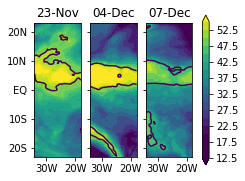

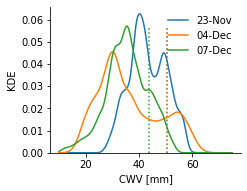

In [24]:
num_sp = len(times_A)

fig, axes = plt.subplots(1, num_sp, figsize=(cm_to_inch(9), cm_to_inch(7)), sharey = True)

for i, time in enumerate(times_A):
        
    #tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))}).values) #.where(LSM['lsm']==0)
    #tmp = np.mean(tmp, axis=0)
    
    tmp = np.squeeze(PWAtl.sel({'time':time}).values)
    tmp_thresh = np.percentile(tmp, per_thresh)
    
    CS = axes[i].contour(lonAtl, latAtl, tmp, [tmp_thresh])#, vmin = 2.7e9, vmax=2.85e9)
    im = axes[i].contourf(lonAtl, latAtl, tmp, 20, vmin = 20, vmax = 57, extend='both')
    axes[i].set_aspect('equal')
    
    locs = axes[i].get_xticks()
    labels = list(np.arange(len(locs)))
    for i_l, loc in enumerate(locs):
        labels[i_l] = '%iW'%int(360-loc)
    axes[i].set_xticklabels(labels) 
    
    axes[i].set_title(pd.to_datetime(time).strftime("%d-%b"))

locs = axes[i].get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
axes[i].set_yticklabels(labels)

cbar = plt.colorbar(im, ax=axes.ravel().tolist())

#plt.suptitle(pd.to_datetime(time).strftime("Year %Y"))
print(pd.to_datetime(time).strftime("Year %Y"))

#plt.tight_layout()

plt.figure(figsize=(cm_to_inch(9), cm_to_inch(7)))

for i, time in enumerate(times_A):

    #tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(3,'D'), time+np.timedelta64(3,'D'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    tmp = np.squeeze(PWAtl.sel({'time':time}).values) 
    x = np.linspace(10,75,161)
    print(time, np.percentile(tmp, per_thresh))
    density = stats.gaussian_kde(np.ndarray.flatten(tmp))
    plt.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"))
    plt.legend(frameon=False)
    plt.vlines([np.percentile(tmp, per_thresh)], 0.0, ymax, linestyle=':', color = 'C%i'%i)
    
ymin, ymax = plt.ylim()
#plt.vlines([48], 0.0, ymax, linestyle=':')
plt.ylim(0.0, ymax)

plt.xlabel('CWV [mm]')
plt.ylabel('KDE')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
plt.tight_layout()

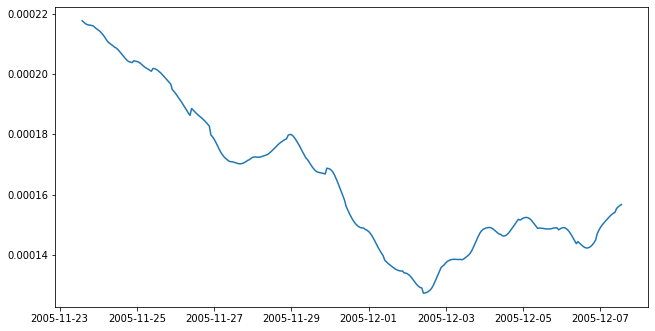

In [26]:
plt.figure(figsize=(cm_to_inch(27), cm_to_inch(14)))
date_startF = times_A[0] 
date_endF   = times_A[-1]

ileftF = find_index(time_A, np.datetime64(date_startF))
irightF = find_index(time_A, np.datetime64(date_endF))
PWAtl_F = PWAtl[ileftF:irightF,:,:]
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(PWAtl_F.values,N_bins=30,V_fixed=Vfinal,bin_fixed=binm_Vfinal)

plt.plot(PWAtl_F.time, Ffinal)
#locs, labels = plt.xticks()
#_=plt.xticks(locs, labels, rotation=45) 

Then use the fixed potential to calculate Landau Free energy over the full period

## Link to contour length

In [27]:
# Calculate Area of domain assuming a rectangle (since we assumed constant dx for the contour)
dx = 110/4 #km
A_domain = PWAtl.shape[1]*PWAtl.shape[2]*(dx**2) #km**2
L_band = 2.0*PWAtl.shape[2]*dx
circle_sw = False

In [28]:
# Calculate MMLI from CON_data assuming band or circle shape

MMLI_PW_data = {}
CONT_PW_data = {}
AREA_PW = {}


YEAR = np.arange(2000,2018)# np.append(np.arange(2000,2014), np.arange(2015,2018)) #2014 is missing!

for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open(path_PKL+'CONTOURL_PW_%i_%i_%i_%i_%i_'%(latmin, latmax, lonmin, lonmax, per_thresh)+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    AREA_PW[str(year)] = tmp["Tot_Area_km2"]
    MMLI_PW_data[str(year)] = 2.0*np.sqrt(np.pi*tmp["Tot_Area_km2"])/tmp['Tot_Contour_km'][str(year)] if circle_sw else L_band/tmp['Tot_Contour_km'][str(year)] #L_band/tmp['Tot_Contour_km'][str(year)]
    CONT_PW_data[str(year)] = tmp['Tot_Contour_km'][str(year)]

In [29]:
cont_t = np.array(get_all_values(CONT_PW_data))

Text(0, 0.5, 'Contour length')

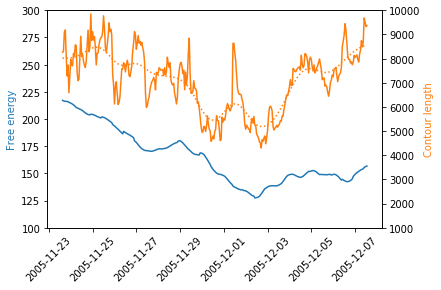

In [31]:
plt.plot(PWAtl_F.time[1:], Ffinal[1:]*1e6)
locs, labels = plt.xticks()
_=plt.xticks(locs, labels, rotation=45) 
plt.ylabel('Free energy', color = 'C0')

time_period = time_A[np.where((time_A>date_startF)&(time_A<date_endF))]
cont_period = cont_t[np.where((time_A>date_startF)&(time_A<date_endF))]

plt.ylim(100, 300)
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax2.plot(time_period, cont_period, 'C1')
ax2.plot(time_period, gaussian_filter1d(cont_period, sigma=12), 'C1:')
#plt.xlim(date_startF[i_d], date_endF[i_d])
plt.ylim(1000, 10000)
plt.ylabel('Contour length', color = 'C1')


In [ ]:
#plt.scatter(cont_period, Ffinal[1:]*1e6)